# Clustering Island based on renewable energy availability

In this notebook we carry out a simple clustering of islands based on renewable energy availability. This is a simple educational project that should help you get started with the [Google Earth Engine](https://earthengine.google.com/) API. The main steps of this project are:
- Extract islands from the [LISB 2017](https://developers.google.com/earth-engine/datasets/catalog/USDOS_LSIB_SIMPLE_2017?hl=it) dataset and the [JRC Global Surface Water Mapping Layers](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_GlobalSurfaceWater?hl=it) dataset by selecting the landmasses that have a prevalence of water surrounding them;
- Associate to the extracted islands solar and wind power availability from the [ERA5-Land Monthly Aggregated](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY_AGGR) dataset.

These steps are useful to start playing around with Google Earth Engine with Python (it is also possible to interact directly with the engine via Javascript). Try to change some parameters (e.g. the `buffer_zone_size`) and see how the detection of islands interactively change. Also the geometries considered could trigger a timeout error and it is useful to try to work around this kind of limitations (e.g. by batching the requests or simplify the geomteries).

## Setup

Here we import the needed libraries and define global variables. To run this step you need to sign up on Google Earth Engine and create a project with a project name. Without loss of generality in the following cell the project name is `*****`. you need to change this variable to your project name. If you cannot connect to Google Earth Engine and working with this API is unconfortable, you can just use the dataset `islands.csv` associated to this project.

In [1]:
import ee
import geemap
import pandas as pd
import time
from datetime import datetime
import json

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
import geopandas as gpd
from shapely.geometry import shape

In [4]:
project_name = '*****'
ee.Authenticate()
ee.Initialize(project=project_name)

In [5]:
area_threshold = 50000
water_threshold = 75
buffer_zone_size = 10000
start_date = '2023-01-01'
end_date = '2023-12-31'

In [6]:
Map = geemap.Map()
start = datetime.strptime(start_date, '%Y-%m-%d')
end = datetime.strptime(end_date, '%Y-%m-%d')
delta = end - start
days = delta.days

## Get islands

To get the islands we consider small landmasses (potential islands) which have a "buffer zone" that intersects water for a hiigh percentage of their territory. Notice that just selecting small landmasses can result in the selection of enclosed areas as Andorra.

In [7]:
# Load Global Landmasses Dataset

countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")

In [8]:
# Add area attribue to filter small landmasses (potential islands)

def add_area(feature):
    area_km2 = feature.geometry().area().divide(1e6)
    return feature.set({'area_km2': area_km2})

countries_with_area = countries.map(add_area)
islands = countries_with_area.filter(ee.Filter.lt('area_km2', area_threshold))

In [9]:
# Water mask around small landmasses

water = ee.Image("JRC/GSW1_0/GlobalSurfaceWater").select('occurrence')
water_mask = water.gt(water_threshold)

def surrounded_by_water(feature, buffer_size = buffer_zone_size):
    geometry = feature.geometry()
    outer = geometry.buffer(buffer_size)
    ring = outer.difference(geometry)
    water_fraction = water_mask.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ring,
        scale=500,
        maxPixels=1e8,
        bestEffort=True
    ).get('occurrence')

    return feature.set({'ring_water_fraction': ee.Number(water_fraction)})


islands_buffered = islands.map(surrounded_by_water)
true_islands = islands_buffered.filter(ee.Filter.gt('ring_water_fraction', 0.99))
true_islands.size().getInfo()

66

In [ ]:
# Visualization

Map.addLayer(true_islands, {"color":"red"}, "Islands")
Map.centerObject(true_islands, 3)
Map.to_html('figures/islands.html', title='Islands Map')
Map

## Extract renewable energy features

We extract renewable energy features and associate them to the previously extracted islands.

In [11]:
# Get solar power over each selected island

solar_ic = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .select("surface_solar_radiation_downwards") \
    .filterDate(start_date,end_date)
solar_mean = solar_ic.mean()
solar_kwh = solar_mean.divide(3.6e6).divide(days).rename("solar_kwh_m2_day")

def add_solar_info(feature):
    mean_solar = solar_kwh.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=feature.geometry(),
        scale=500,
        maxPixels=1e8,
        bestEffort=True
    ).get('solar_kwh_m2_day')
    return feature.set({'solar_kwh_m2_day': mean_solar})

islands_with_solar = true_islands.map(add_solar_info)

In [12]:
# Extract solar power to pandas DataFrame

features = islands_with_solar.getInfo()['features']
data = []
for f in features:
    props = f['properties']
    props['geometry'] = f['geometry']
    data.append(props)

df = pd.DataFrame(data)

In [13]:
print(df[['area_km2', 'solar_kwh_m2_day']])

       area_km2  solar_kwh_m2_day
0    370.920266          0.002318
1   1653.624023          0.007925
2   4077.450215          0.004975
3   7413.450658          0.005780
4    792.369801          0.004998
..          ...               ...
61   434.544723          0.000008
62    51.978745          0.000008
63   142.020200          0.000008
64    63.980582          0.000008
65   234.672541          0.000008

[66 rows x 2 columns]


In [14]:
# Repeat for wind power

u_wind = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .select("u_component_of_wind_10m") \
    .filterDate(start_date, end_date) \
    .mean()

v_wind = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .select("v_component_of_wind_10m") \
    .filterDate(start_date, end_date) \
    .mean()

#wind speed = sqrt(u^2 + v^2)
wind_speed = u_wind.pow(2).add(v_wind.pow(2)).sqrt().rename("wind_speed_10m")

def add_wind_info(feature):
    mean_wind = wind_speed.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=feature.geometry(),
        scale=500,
        maxPixels=1e8,
        bestEffort=True
    ).get('wind_speed_10m')
    return feature.set({'wind_speed_10m': mean_wind})


islands_with_wind = islands_with_solar.map(add_wind_info)

In [15]:
# Extract wind power to pandas DataFrame

features = islands_with_wind.getInfo()['features']
data = []
for f in features:
    props = f['properties']
    props['geometry'] = f['geometry']
    data.append(props)

df = pd.DataFrame(data)

In [16]:
print(df[['area_km2', 'solar_kwh_m2_day', 'wind_speed_10m']])#'ring_water_fraction'

       area_km2  solar_kwh_m2_day  wind_speed_10m
0    370.920266          0.002318        1.129254
1   1653.624023          0.007925        0.844888
2   4077.450215          0.004975        6.420093
3   7413.450658          0.005780        4.527886
4    792.369801          0.004998        2.363956
..          ...               ...             ...
61   434.544723          0.000008             NaN
62    51.978745          0.000008             NaN
63   142.020200          0.000008             NaN
64    63.980582          0.000008             NaN
65   234.672541          0.000008             NaN

[66 rows x 3 columns]


## Clustering

Here we carry out a simple clustering of the selected islands based on the renewable energy availability.

In [17]:
# Preparing dataset for clustering

df_clean = df.dropna(subset=['solar_kwh_m2_day', 'wind_speed_10m'])
X = df_clean[['solar_kwh_m2_day', 'wind_speed_10m']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

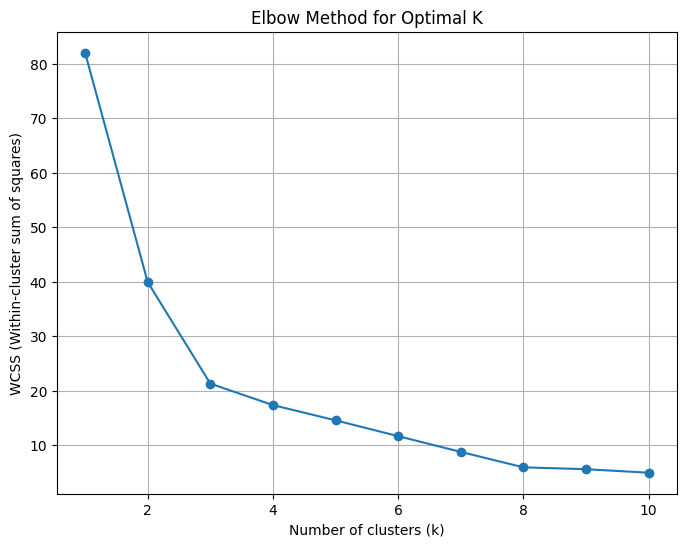

In [18]:
# K-means with elbow method

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-cluster sum of squares)')
plt.grid(True)
plt.show()

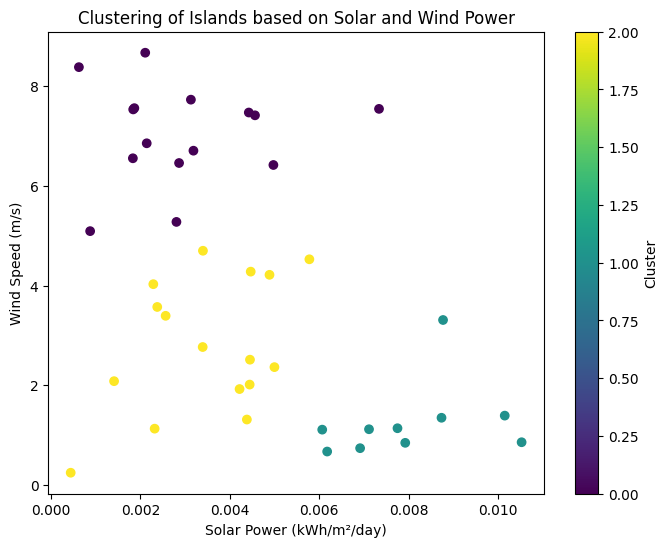

In [19]:
# Clusters in feature space

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(df_clean['solar_kwh_m2_day'], df_clean['wind_speed_10m'], c=df_clean['cluster'], cmap='viridis')
plt.title('Clustering of Islands based on Solar and Wind Power')
plt.xlabel('Solar Power (kWh/m²/day)')
plt.ylabel('Wind Speed (m/s)')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# Clustered dataframe

df_clean['geometry'] = df_clean['geometry'].apply(shape)
gdf = gpd.GeoDataFrame(df_clean, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)

In [ ]:
# Clusters in "state" space

geojson_str = gdf.to_json()
geojson_obj = json.loads(geojson_str)
cluster_fc = geemap.geojson_to_ee(geojson_obj)
cluster_colors = ['yellow', 'blue', 'green']

Map.clear()
for i, color in enumerate(cluster_colors):
    cluster_i = cluster_fc.filter(ee.Filter.eq('cluster', i))
    Map.addLayer(cluster_i.style(**{'color': color}), {}, f'Cluster {i}')

Map.to_html('figures/clustered_islands.html', title='Clustered Islands Map')
Map

## Dataset extraction

If you couldn't run properly this notebook you can use this extracted csv file as starting point for the clustering: import the file as pandas dataframe and repeat the clustering steps.

In [22]:
gdf_no_cluster = gdf.drop(columns=['cluster'])
gdf_no_cluster.to_csv('data/islands.csv', index=False)